## Fitting a world model to the Point Maze environment

In [1]:
from torch.utils.data import TensorDataset, DataLoader
import gymnasium as gym
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec
import seaborn as sns
from stable_baselines3 import PPO

/Users/cl1704/anaconda3/envs/myoenv/lib/python3.8/site-packages/gymnasium/envs/registration.py:596: UserWarning: WARN: plugin: shimmy.registration:register_gymnasium_envs raised Traceback (most recent call last):
  File "/Users/cl1704/anaconda3/envs/myoenv/lib/python3.8/site-packages/gymnasium/envs/registration.py", line 594, in load_plugin_envs
    fn()
  File "/Users/cl1704/anaconda3/envs/myoenv/lib/python3.8/site-packages/shimmy/registration.py", line 303, in register_gymnasium_envs
    _register_dm_control_envs()
  File "/Users/cl1704/anaconda3/envs/myoenv/lib/python3.8/site-packages/shimmy/registration.py", line 63, in _register_dm_control_envs
    from shimmy.dm_control_compatibility import DmControlCompatibilityV0
  File "/Users/cl1704/anaconda3/envs/myoenv/lib/python3.8/site-packages/shimmy/dm_control_compatibility.py", line 16, in <module>
    from dm_control import composer
  File "/Users/cl1704/anaconda3/envs/myoenv/lib/python3.8/site-packages/dm_control/composer/__init__.py

### Defining the world model as PyTorch module
The WorldNet module takes an intial state and a policy as input and outputs a simulated trajectory. This trajectory gives the predicted state for each previous state and action as well as the predicted reward.

In [2]:
class WorldNet(nn.Module):
    def __init__(self,actor_network):
        super(WorldNet, self).__init__()
        # Dimension of environment state
        self.STATE_DIM = 6
        # Number steps to simulate in a foward pass.
        self.N_STEPS = 100
        # Policy network
        self.actor_network = actor_network
        # Non-linear function for mapping (state,action) pairs to states.
        self.f = torch.nn.Sequential(nn.Linear(8,16,bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(16,32,bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(32,64,bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(64,128,bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(128,64,bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(64,32,bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(32,16,bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(16,8,bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(8,6,bias=True),
                                  )
        # Linear transformation for computing rewards from states.
        self.mlp_reward = nn.Linear(6,2,bias=True)
    def forward(self, u):
        '''
        :param u: Batch of initial environment states of shape (batch_size x state_dim)
        :return: Sequence of predicted states and rewards
        '''
        
        # Set initial state
        x = torch.zeros(u.shape[0],1,self.STATE_DIM)
        x[:,0,:] = u
        
        # State, x, evolves over time. Updates are non-linear functions of the state (p,v,g) and the action.
        for t in range(1,self.N_STEPS+1):
            x_new = x[:,t-1,:] +  self.f(torch.hstack([x[:,t-1,:],self.actor_network(x[:,t-1,:])]))
            x = torch.cat((x, x_new.unsqueeze_(1)), 1)
            
        # Calculate reward for each episode and time.
        reward_prediction = torch.exp(-torch.sqrt(torch.sum(self.mlp_reward(x[:,1:,:])**2,dim=2,keepdim=True)))
        
        # Return concatenation of states and rewards.
        return torch.concatenate([x[:,:-1,:], reward_prediction],dim=2)
    
    
class ActorNet(nn.Module):
    def __init__(self):
        super(ActorNet, self).__init__()
        
        self.mlp = nn.Sequential(nn.Linear(6,8,bias=True),
                                       nn.ReLU(),
                                       nn.Linear(8,16,bias=True),
                                       nn.ReLU(),
                                       nn.Linear(16,32,bias=True),
                                 nn.ReLU(),
                                       nn.Linear(32,16,bias=True),
                                 nn.ReLU(),
                                        nn.Linear(16,8,bias=True),
                                 nn.ReLU(),
                                       nn.Linear(8,2,bias=True))
    def forward(self, x):

        return self.mlp(x)
    



In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import gymnasium as gym
import numpy as np
import torch.nn as nn
# %%

device = 'mps'

class WorldNet(nn.Module):
    def __init__(self, actor_network):
        super(WorldNet, self).__init__()
        self.STATE_DIM = 6
        self.N_STEPS = 100
        self.actor_network = actor_network

        # Take state and action and ouput new state
        self.f = torch.nn.Sequential(nn.Linear(8, 16, bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(16, 32, bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(32, 64, bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(64, 128, bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(128, 64, bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(64, 32, bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(32, 16, bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(16, 8, bias=True),
                                     nn.ReLU6(),
                                     nn.Linear(8, 6, bias=True),
                                     )
        self.mlp_reward = nn.Linear(6, 2, bias=True)

    def forward(self, u):
        '''
        :param u: batch_size  x 6+2 (batch of initial_states)
        :return: Sequence of states and rewards
        '''
        # Initial state (position, velocity, goal)
        x = torch.zeros(u.shape[0], 1, self.STATE_DIM).to(device)
        x[:, 0, :] = u

        # State, x, evolves over time. Updates are non-linear functions of the state (p,v,g) and the action.
        for t in range(1, self.N_STEPS + 1):
            x_new = x[:, t - 1, :] + self.f(torch.hstack([x[:, t - 1, :], self.actor_network(x[:, t - 1, :])]))
            x = torch.cat((x, x_new.unsqueeze_(1)), 1)

        # Calculate reward for each episode and time.
        reward_prediction = torch.exp(-torch.sqrt(torch.sum(self.mlp_reward(x[:, 1:, :]) ** 2, dim=2, keepdim=True)))
        return torch.concatenate([x[:, :-1, :], reward_prediction], dim=2)

class ActorNet(nn.Module):
    def __init__(self):
        super(ActorNet, self).__init__()

        self.mlp = nn.Sequential(nn.Linear(6, 8, bias=True),
                                 nn.ReLU(),
                                 nn.Linear(8, 16, bias=True),
                                 nn.ReLU(),
                                 nn.Linear(16, 32, bias=True),
                                 nn.ReLU(),
                                 nn.Linear(32, 16, bias=True),
                                 nn.ReLU(),
                                 nn.Linear(16, 8, bias=True),
                                 nn.ReLU(),
                                 nn.Linear(8, 2, bias=True))

    def forward(self, x):
        return self.mlp(x)


print('generating data')
# Generate data for world model

MEDIUM_MAZE = [
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 0, 0, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 1, 1, 1, 1, 1, 0, 1],
    [1, 0, 0, 0, 0, 0, 0, 1],
    [1, 1, 1, 1, 1, 1, 1, 1]]

# Initialize environment with this map for training.
env = gym.make('PointMaze_MediumDense-v3',
               max_episode_steps=100, maze_map=MEDIUM_MAZE,
               render_mode='rgb_array'
               )

# Initialize networks
actor_network = ActorNet().to(device)
world_network = WorldNet(actor_network = actor_network).to(device)

# Creat dataset
def generate_experience(actor,device):
    NUM_EPISODES = 1000
    MAX_STEPS = 100
    inputs = torch.zeros(NUM_EPISODES, 6)
    labels = torch.zeros(NUM_EPISODES, MAX_STEPS, 7)
    for episode in range(NUM_EPISODES):
        # Initialize new actor
    
        # Reset environment
        state = env.reset()
        # Reshape state variable
        state = torch.tensor(np.concatenate([state[0]['observation'], state[0]['desired_goal']])).float()
        inputs[episode, :] = state
    
        for step in range(MAX_STEPS):
            action = actor(state.to(device))
            # Take step in environment to get new state and reward
            new_state, reward, _, _, _ = env.step(action.detach().cpu())
            new_state = torch.tensor(np.concatenate([new_state['observation'], new_state['desired_goal']])).float()
    
            # Add data 
            labels[episode, step, :] = torch.hstack([state, torch.tensor(reward).float()])
    
            # Set current state to new state
            state = new_state.clone()
            
    inputs = inputs.to(device)
    labels = labels.to(device)
    return inputs, labels





NUM_EPOCHS = 100


    # Train world model
    print('Training world net')
    
    inputs,labels = generate_experience(actor_network,device)
    my_dataset = TensorDataset(inputs, labels)  #
    my_dataloader = DataLoader(my_dataset, batch_size=256, shuffle=True)
    
    # Turn gradients for actor
    for param in world_network.actor_network.parameters():
        param.requires_grad_(False)
    for param in world_network.f.parameters():
        param.requires_grad_(True)
    for param in world_network.mlp_reward.parameters():
        param.requires_grad_(True)

    optimizer = torch.optim.Adam(world_network.parameters(), lr=.001, weight_decay=0)
    
    # Training loop
    for i in range(NUM_EPOCHS):
        epoch_loss = 0
        for batch_idx, (u_batch, z_batch) in enumerate(my_dataloader):
            optimizer.zero_grad()
            x_batch = world_network.forward(u_batch)
            z_batch_centered  = z_batch - torch.mean(z_batch,dim=1,keepdim=True)
            x_batch_centered = x_batch - torch.mean(x_batch,dim=1,keepdim=True)
            loss = torch.nn.MSELoss()(x_batch, z_batch) 
            epoch_loss += loss.item() / NUM_EPOCHS
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(world_network.parameters(), max_norm=.1)
            optimizer.step()
    
        if i % 50 == 0:
            outputs = world_network.forward(inputs)
            print('Epoch: {}/{}.............'.format(i, NUM_EPOCHS), end=' ')
            labels_centered  = labels - torch.mean(labels,dim=1,keepdim=True)
            print("mse_z: {:.8f}".format(torch.nn.MSELoss()(outputs,labels).item()/ torch.nn.MSELoss()(torch.zeros_like(labels_centered), labels_centered).item()))
            torch.save(world_network,'world_network.pth')
            torch.save(actor_network, 'actor_network.pth')
            #loss_history.append(epoch_loss)

    # TRAIN ACTOR
    for param in world_network.actor_network.parameters():
        param.requires_grad_(True)
    for param in world_network.f.parameters():
        param.requires_grad_(False)
    for param in world_network.mlp_reward.parameters():
        param.requires_grad_(False)
    optimizer = torch.optim.Adam(world_network.parameters(), lr=0.001)
    
    for i in range(NUM_EPOCHS):
        epoch_loss = 0
        for batch_idx, (u_batch, z_batch) in enumerate(my_dataloader):
            optimizer.zero_grad()
            x_batch = world_network.forward(u_batch)

            loss = -torch.sum(x_batch[:, :, -1])
            epoch_loss += loss.item() / NUM_EPOCHS
            loss.backward()
            # torch.nn.utils.clip_grad_norm_(world_network.parameters(), max_norm=.1)
            optimizer.step()
        if i % 50 == 0:
            outputs = world_network.forward(inputs)
            print('Epoch: {}/{}.............'.format(i, NUM_EPOCHS), end=' ')

            print("Reward: {:.8f}".format(torch.sum(outputs[:, :, -1])))
            torch.save(world_network, 'world_network.pth')
            torch.save(actor_network, 'actor_network.pth')
            #loss_history.append(epoch_loss) 



generating data
Training world net
Epoch: 0/100............. mse_z: 203.29037563


NameError: name 'loss_history' is not defined

## Generate data to train world model


In [3]:
# Generate data for world model
NUM_EPISODES = 1000
MAX_STEPS = 100
MEDIUM_MAZE = [
            [1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 0, 1],
            [1, 1, 1, 1, 1, 1, 0, 1],
            [1, 1, 1, 1, 1, 1, 0, 1],
            [1, 1, 1, 1, 1, 1, 0, 1],
            [1,0,0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1]]

# Initialize environment with this map for training.
env = gym.make('PointMaze_MediumDense-v3',
               max_episode_steps=100,maze_map= MEDIUM_MAZE,
               render_mode = 'rgb_array'
)


# Loop over episodes
inputs = torch.zeros(NUM_EPISODES,6)
labels = torch.zeros(NUM_EPISODES,MAX_STEPS,7)
actor_network = ActorNet()
for episode in range(NUM_EPISODES):
    # Initialize new actor
    
    # Reset environment
    state = env.reset()
    # Reshape state variable
    state = torch.tensor(np.concatenate([state[0]['observation'],state[0]['desired_goal']])).float()
    inputs[episode ,:] = state
#     weights = np.random.choice(2, size=2, p=[.5, .5])
#     weights = torch.tensor(weights, dtype=torch.float32)
#     dist1 = torch.normal(mean=0.5, std=0.2,size=[2])
#     dist2 = torch.normal(mean=-0.5, std=0.2,size=[2])
# #
    #action = weights * dist1 + (1 - weights) * dist2
    
   # action =  1.5*(torch.rand(2)-.5).float()
    for step in range(MAX_STEPS):
        action = actor_network(state)
        # Take step in environment to get new state and reward
        new_state, reward, _, _,_ = env.step(action.detach())
        new_state = torch.tensor(np.concatenate([new_state['observation'],new_state['desired_goal']])).float()
        
        # Add data 
        labels[episode,step,:] = torch.hstack([state,torch.tensor(reward).float()])
    
        # Set current state to new state
        state = new_state.clone()
# input = torch.vstack(input)
# labels = torch.vstack(labels)
# Inputs give state

# Train world net

In [4]:
#world_network  = torch.load('world_network.pth',map_location='cpu',weights_only=False)

In [7]:

world_network = WorldNet(actor_network = actor_network)
for param in world_network.actor_network.parameters():
    param.requires_grad_(False)
#world_network  = torch.load('world_network.pth')
# Initialize optimizer and wrap training data as PyTorch dataset
optimizer = torch.optim.Adam(world_network.parameters(), lr=.001,weight_decay = 0)
my_dataset = TensorDataset(inputs, labels)  #
my_dataloader = DataLoader(my_dataset, batch_size=256,shuffle=True)

NUM_EPOCHS = 10000
# Training loop
loss_history = []

for i in range(NUM_EPOCHS):
    epoch_loss = 0
    for batch_idx, (u_batch, z_batch) in enumerate(my_dataloader):
        optimizer.zero_grad()
        x_batch = world_network.forward(u_batch)
        z_batch_centered  = z_batch - torch.mean(z_batch,dim=1,keepdim=True)
        x_batch_centered = x_batch - torch.mean(x_batch,dim=1,keepdim=True)
        loss = torch.nn.MSELoss()(x_batch, z_batch) 
        epoch_loss += loss.item() / NUM_EPOCHS
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(world_network.parameters(), max_norm=.1)
        optimizer.step()

    if i % 50 == 0:
        outputs = world_network.forward(inputs)
        print('Epoch: {}/{}.............'.format(i, NUM_EPOCHS), end=' ')
        labels_centered  = labels - torch.mean(labels,dim=1,keepdim=True)
        print("mse_z: {:.8f}".format(torch.nn.MSELoss()(outputs,labels).item()/ torch.nn.MSELoss()(torch.zeros_like(labels_centered), labels_centered).item()))
        torch.save(world_network,'world_network.pth')
        loss_history.append(epoch_loss) 


Epoch: 0/10000............. mse_z: 320.95914829
Epoch: 50/10000............. mse_z: 1.53384746
Epoch: 100/10000............. mse_z: 0.98408151
Epoch: 150/10000............. mse_z: 0.60979976
Epoch: 200/10000............. mse_z: 0.48373722
Epoch: 250/10000............. mse_z: 0.44107952
Epoch: 300/10000............. mse_z: 0.41921771
Epoch: 350/10000............. mse_z: 0.40296190
Epoch: 400/10000............. mse_z: 0.39069909
Epoch: 450/10000............. mse_z: 0.37737423
Epoch: 500/10000............. mse_z: 0.41002027
Epoch: 550/10000............. mse_z: 0.35570416


KeyboardInterrupt: 

In [5]:
outputs = world_network.forward(inputs)

rows = []
for episode in range(labels.shape[0]):
    for step in range(labels.shape[1]):
        rows.append({'episode':episode,
                     'step': step,
                    'x':labels[episode,step,0].item(),
                     'y':labels[episode,step,1].item(),
                     'x_pred':outputs[episode,step,0].item(),
                     'y_pred':outputs[episode,step,1].item()})
df = pd.DataFrame(rows)

In [14]:
inputs.shape

torch.Size([1000, 6])

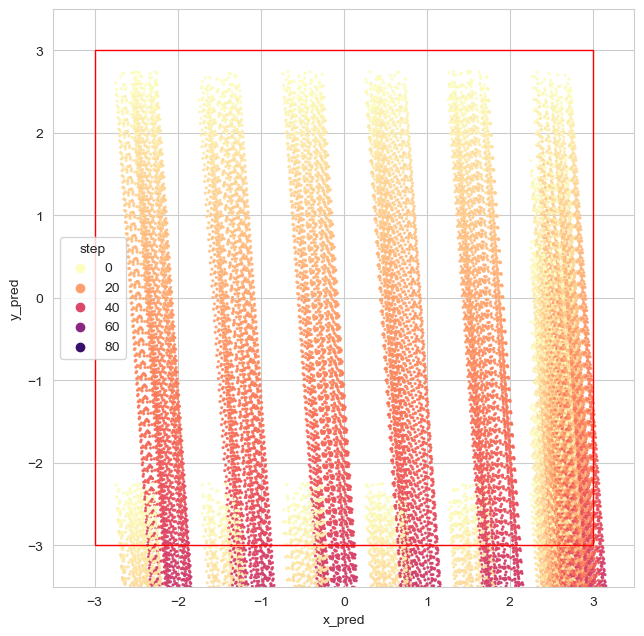

In [7]:


fig = plt.figure(figsize=(7.5,7.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
episode = 220

#sns.scatterplot(data = df[df.episode>0], x = 'x', y = 'y',hue = 'step',ax=ax,edgecolor=None,alpha=.5,s=4)
sns.scatterplot(data = df[df.episode>0], x = 'x_pred', y = 'y_pred',ax=ax,edgecolor=None,s=4,hue = 'step',palette = 'magma_r')
ax.set_xlim(-3.5,3.5)
ax.set_ylim(-3.5,3.5)
import matplotlib
rect = matplotlib.patches.Rectangle((-3, -3), 6,6, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)


<Axes: xlabel='x_pred', ylabel='x'>

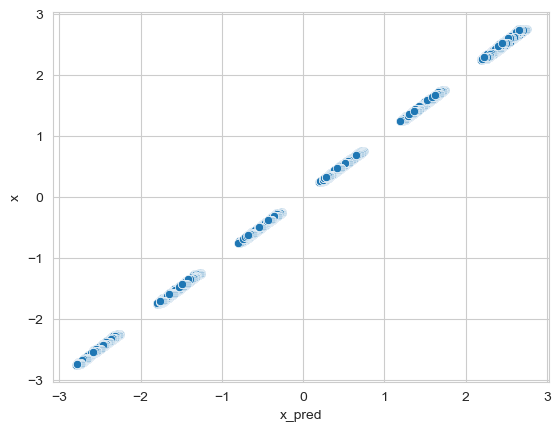

In [10]:
plt.figure()
sns.scatterplot(data = df, x = 'x_pred', y = 'x')

In [ ]:
# TRAIN ACTOR WITH WORLD MODEL
## Use actor to generate simulated trajectories 
NUM_EPISODES = 5000

MAX_STEPS = 100
MEDIUM_MAZE = [
            [1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 0, 1],
            [1, 1, 1, 1, 1, 1, 'g', 1],
            [1, 1, 1, 1, 1, 1, 0, 1],
            [1, 1, 1, 1, 1, 1, 0, 1],
            [1,0,0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1]]

# Initialize environment with this map for training.
env = gym.make('PointMaze_Medium-v3',
               max_episode_steps=100,maze_map= MEDIUM_MAZE,
               render_mode = 'rgb_array'
)

# # Initialize networks
actor_network = ActorNet()
world_network = WorldNet(actor_network = actor_network)
world_network.N_STEPS = 100
for param in world_network.actor_network.parameters():
    param.requires_grad_(True)
for param in world_network.f.parameters():
    param.requires_grad_(False)
for param in world_network.mlp_reward.parameters():
    param.requires_grad_(False)
    


#Optimizers
#world_optimizer = torch.optim.Adam(world_network.parameters(), lr=1e-5)
actor_optimizer = torch.optim.Adam(world_network.parameters(), lr=0.001)

my_dataset = TensorDataset(inputs, labels)  #
my_dataloader = DataLoader(my_dataset, batch_size=256,shuffle=True)

NUM_EPOCHS = 10000
# Training loop
loss_history = []
torch.autograd.set_detect_anomaly(True)
for i in range(NUM_EPOCHS):
    epoch_loss = 0
    for batch_idx, (u_batch, z_batch) in enumerate(my_dataloader):
        actor_optimizer.zero_grad()
        x_batch = world_network.forward(u_batch)

        loss = -torch.sum(x_batch[:,:,-1])
        epoch_loss += loss.item() / NUM_EPOCHS
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(world_network.parameters(), max_norm=.1)
        actor_optimizer.step()

    if i % 50 == 0:
        outputs = world_network.forward(inputs)
        print('Epoch: {}/{}.............'.format(i, NUM_EPOCHS), end=' ')

        print("mse_z: {:.8f}".format(torch.sum(outputs[:,:,-1])))
        torch.save(world_network,'world_network.pth')
        loss_history.append(epoch_loss) 


# # Loop over episodes
# episode_rewards = []
# world_losses = []
# for episode in range(NUM_EPISODES):
#     if episode % 100==0:
#         print(episode)
# 
#     
#     # Imagined trajectory
#     state = env.reset()
#     state = torch.tensor(np.concatenate([state[0]['observation'],state[0]['desired_goal']])).float()
#     state = state[None,None,:]
# 
#     total_reward_prediction = 0
#     for step in range(MAX_STEPS):
#         action = actor_network(state)
#  
#         prediction = world_network(torch.concatenate([state,action],dim=2))
# 
#         new_state_prediction = prediction[:,:,:-1]
#         reward_prediction = prediction[:,:,-1]
#         total_reward_prediction += reward_prediction
#          # Update total rewards
#         state = new_state_prediction
#         total_reward_prediction += reward_prediction
# 
#     actor_network.zero_grad()
#     actor_loss = -total_reward_prediction
#     actor_loss.backward()
#     actor_optimizer.step()
#         
#     if episode % 5==0:
#         print('actor loss: ', actor_loss.item() )
#         #print('world loss: ', world_loss.item() )
#         #print('rewards: ', rewards.item() )
#         
# env.close()
    # Experiment_1.insert1(results)


In [113]:


NUM_EPOCHS = 10000
# Training loop
loss_history = []

for i in range(NUM_EPOCHS):
    epoch_loss = 0
    for batch_idx, (u_batch, z_batch) in enumerate(my_dataloader):
        optimizer.zero_grad()
        x_batch = world_network.forward(u_batch)
        z_batch_centered  = z_batch - torch.mean(z_batch,dim=1,keepdim=True)
        x_batch_centered = x_batch - torch.mean(x_batch,dim=1,keepdim=True)
        loss = torch.nn.MSELoss()(x_batch, z_batch) 
        epoch_loss += loss.item() / NUM_EPOCHS
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(world_network.parameters(), max_norm=.1)

        optimizer.step()

    if i % 50 == 0:
        outputs = world_network.forward(inputs)
        print('Epoch: {}/{}.............'.format(i, NUM_EPOCHS), end=' ')
        labels_centered  = labels - torch.mean(labels,dim=1,keepdim=True)
        print("mse_z: {:.8f}".format(torch.nn.MSELoss()(outputs,labels).item()/ torch.nn.MSELoss()(torch.zeros_like(labels_centered), labels_centered).item()))
        torch.save(world_network,'world_network.pth')
        loss_history.append(epoch_loss) 


tensor([[[-2.7015,  2.4815,  0.0000,  0.0000, -2.7382, -2.3351]]],
       grad_fn=<SliceBackward0>)

In [94]:
total_reward_prediction.shape

torch.Size([1, 7])

In [63]:
torch.hstack([state,action])[None,:].shape

torch.Size([1, 8])

# Test world model

# Train actor with world model 

<Axes: xlabel='x', ylabel='y'>

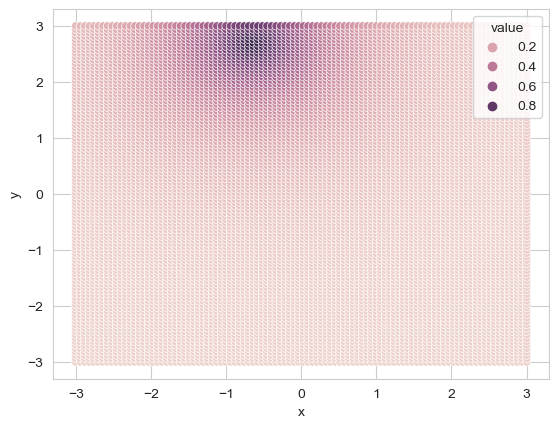

In [7]:
import pandas as pd
import seaborn as sns
rows = []
for x in np.linspace(-3,3,100):
    for y in np.linspace(-3,3,100):
        new_state_prediction = world_network(torch.concatenate([torch.tensor([x,y,0,0,-0.6502,  2.7092]),torch.tensor([0,0])]).float()[None,None,:])
    
        rows.append({'x':x,'y':y,'value':new_state_prediction[0,0,-1].item()})
df = pd.DataFrame(rows)
sns.scatterplot(x='x',y='y',hue='value',data=df)

<Axes: xlabel='x', ylabel='y'>

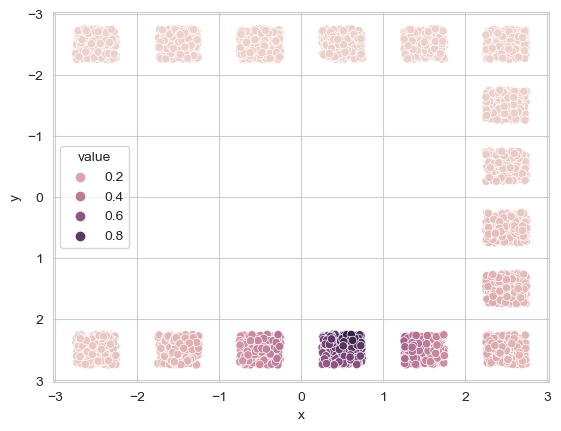

In [20]:
import pandas as pd
import seaborn as sns
rows = []
for i in range(4000):
    state = env.reset()
    state = torch.tensor(np.concatenate([state[0]['observation'],state[0]['desired_goal']])).float()
    #new_state_prediction = world_network(torch.concatenate([state,torch.tensor([0,0])]).float()[None,None,:])

    new_state_prediction = world_network(torch.concatenate([torch.tensor([state[0],state[1],0,0,0.5547,  2.2752]),torch.tensor([0,0])]).float()[None,None,:])


    rows.append({'x':state[0],'y':state[1],'value':new_state_prediction[0,0,-1].item()})
df = pd.DataFrame(rows)
sns.scatterplot(x='x',y='y',hue='value',data=df)

In [14]:
world_network  = torch.load('world_network.pth',map_location='cpu',weights_only=False)
actor_network  = torch.load('actor_network.pth',map_location='cpu',weights_only=False)

inputs,labels = generate_experience(actor_network,'cpu')
outputs = world_network.forward(inputs)

RuntimeError: Tensor for argument weight is on cpu but expected on mps

In [ ]:
rows = []
for episode in range(outputs.shape[0]):
    for t in range(outputs.shape[1]):
        rows.append({'episode':episode,
                     't':t,
                     'x': outputs[episode,t,0].item(),
                     'y': outputs[episode,t,1].item(),
                     'reward': outputs[episode,t,-1].item(),})
        
df = pd.DataFrame(rows)
sns.scatterplot(x='x',y='y',hue='reward',data=df)

## Use world model to train actor

In [10]:
# VISUALIZE TRAINING
import time
from collections import deque

NUM_EPISODES = 2000

MAX_STEPS = 100
MEDIUM_MAZE = [
            [1, 1, 1, 1, 1, 1, 1, 1],
            [1, 0, 0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 0, 1],
            [1, 1, 1, 1, 1, 1, 'r', 1],
            [1, 1, 1, 1, 1, 1, 0, 1],
            [1, 1, 1, 1, 1, 1, 0, 1],
            [1,'g',0, 0, 0, 0, 0, 1],
            [1, 1, 1, 1, 1, 1, 1, 1]]

# Initialize environment with this map for training.
env = gym.make('PointMaze_MediumDense-v3',
               max_episode_steps=100,maze_map= MEDIUM_MAZE,
               render_mode = 'rgb_array'
)

# # Initialize networks
actor_network = ActorNet()


#Optimizers
#world_optimizer = torch.optim.Adam(world_network.parameters(), lr=1e-5)
actor_optimizer = torch.optim.Adam(actor_network.parameters(), lr=1e-4)

# Loop over episodes
episode_rewards = []
world_losses = []
rows = []
state = env.reset()
init_state = torch.tensor(np.concatenate([state[0]['observation'],state[0]['desired_goal']])).float()

for episode in range(NUM_EPISODES):
    
    if episode % 100==0:
        print(episode)

    
    # Imagined trajectory
    #state = env.reset()
    #state = torch.tensor(np.concatenate([state[0]['observation'],state[0]['desired_goal']])).float()
    state = init_state.clone()
    state = state[None,None,:]
    rows.append({'t':0,
                 'x':state[:,:,0],
                 'y':-state[:,:,1],
                 'episode':episode})
    total_reward_prediction = 0
    for step in range(MAX_STEPS):
        action = actor_network(state)
        
        prediction = world_network(torch.concatenate([state,action],dim=2))
        print(prediction)
        new_state_prediction = prediction[:,:,:-1]
        
        reward_prediction = prediction[:,:,-1]
        total_reward_prediction += reward_prediction
         # Update total rewards
        state = new_state_prediction.clone()
       # total_reward_prediction += reward_prediction
         # Update total rewards
        #state = new_state_prediction
        
        rows.append({'t':step+1,
                 'x':state[:,:,0].item(),
                 'y':-state[:,:,1].item(),
                 'episode':episode})
        total_reward_prediction += reward_prediction

    actor_network.zero_grad()
    actor_loss = -total_reward_prediction
    actor_loss.backward()
    actor_optimizer.step()
    
    
    if episode % 5==0:
        print('actor loss: ', actor_loss.item() )
        #print('world loss: ', world_loss.item() )
        #print('rewards: ', rewards.item() )
       
env.close()
    # Experiment_1.insert1(results)


0
tensor([[[ 2.3600,  0.2684,  0.0000,  0.0000, -2.3077, -2.6372,  0.0040]]],
       grad_fn=<CatBackward0>)
tensor([[[ 2.3600,  0.2684,  0.0000,  0.0000, -2.3077, -2.6372,  0.0040]]],
       grad_fn=<CatBackward0>)
tensor([[[ 2.3600,  0.2684,  0.0000,  0.0000, -2.3077, -2.6372,  0.0040]]],
       grad_fn=<CatBackward0>)
tensor([[[ 2.3600,  0.2684,  0.0000,  0.0000, -2.3077, -2.6372,  0.0040]]],
       grad_fn=<CatBackward0>)
tensor([[[ 2.3600,  0.2684,  0.0000,  0.0000, -2.3077, -2.6372,  0.0040]]],
       grad_fn=<CatBackward0>)
tensor([[[ 2.3600,  0.2684,  0.0000,  0.0000, -2.3077, -2.6372,  0.0040]]],
       grad_fn=<CatBackward0>)
tensor([[[ 2.3600,  0.2684,  0.0000,  0.0000, -2.3077, -2.6372,  0.0040]]],
       grad_fn=<CatBackward0>)
tensor([[[ 2.3600,  0.2684,  0.0000,  0.0000, -2.3077, -2.6372,  0.0040]]],
       grad_fn=<CatBackward0>)
tensor([[[ 2.3600,  0.2684,  0.0000,  0.0000, -2.3077, -2.6372,  0.0040]]],
       grad_fn=<CatBackward0>)
tensor([[[ 2.3600,  0.2684,  0.0000

KeyboardInterrupt: 

<Axes: xlabel='x', ylabel='y'>

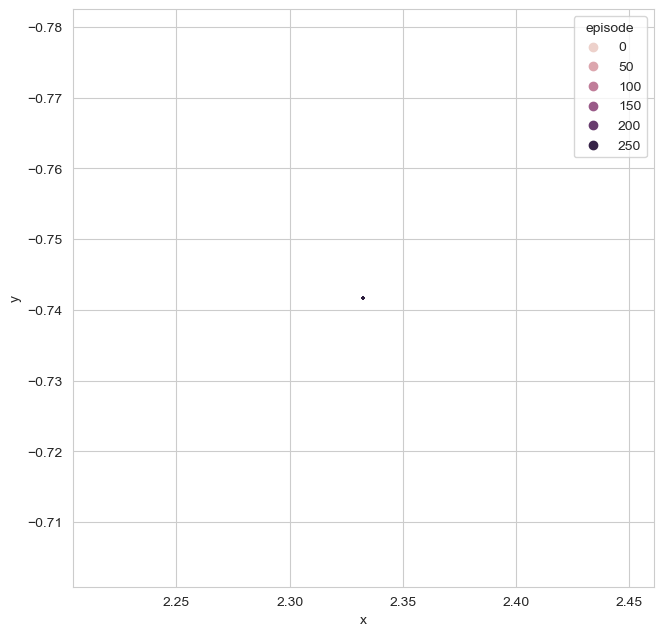

In [9]:
df = pd.DataFrame(rows)
fig = plt.figure(figsize=(7.5,7.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])

import matplotlib
rect = matplotlib.patches.Rectangle((-3, -3), 6,6, linewidth=1, edgecolor='r', facecolor='none')

# Add the patch to the Axes
#ax.add_patch(rect)
sns.scatterplot(data = df, x = 'x',y='y',hue = 'episode',edgecolor=None,s=3)

In [33]:
df

,t,x,y,episode
0,0,[[tensor(0.2748)]],[[tensor(-2.6529)]],0
1,1,0.274784,-2.652925,0
2,2,0.274784,-2.652925,0
3,3,0.274784,-2.652925,0
4,4,0.274784,-2.652925,0
...,...,...,...,...
17973,96,0.274784,-2.652925,177
17974,97,0.274784,-2.652925,177
17975,98,0.274784,-2.652925,177
17976,99,0.274784,-2.652925,177


## Test trained actor

In [153]:
import time
from collections import deque

NUM_EPISODES = 100

MAX_STEPS = 100


# Initialize environment with this map for training.
env = gym.make('PointMaze_Medium-v3',
               max_episode_steps=100,maze_map= MEDIUM_MAZE,
               render_mode = 'human'
)



for episode in range(NUM_EPISODES):
    
    if episode % 100==0:
        print(episode)

    
    # Imagined trajectory
    state = env.reset()
    state = torch.tensor(np.concatenate([state[0]['observation'], state[0]['desired_goal']])).float()
    #state = init_state
    for step in range(MAX_STEPS):
        env.render()
        action = actor_network(state)
        new_state, reward, _, _,_ = env.step(action.detach())
        state = torch.tensor(np.concatenate([new_state['observation'],new_state['desired_goal']])).float()
        print(reward)
env.close()
    # Experiment_1.insert1(results)


0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.

KeyboardInterrupt: 

In [141]:
env.close()

In [267]:
initial_state = env.reset()
initial_state = torch.tensor(np.concatenate([initial_state[0]['observation'],initial_state[0]['desired_goal']])).float()
world_network.eval()
actor_network = ActorNet()
actor_network.train()
actor_optimizer = torch.optim.Adam(actor_network.parameters(), lr=1e-4)
rows = []
for run in range(1000):
    state = initial_state.clone()
    
    total_reward_prediction = 0
    for step in range(MAX_STEPS):
        # Take step in environment 
        action = actor_network(state)
        
        new_state_prediction,reward_prediction = world_network(torch.concatenate([state,action]))
        total_reward_prediction += reward_prediction
        rows.append({'run':run,'step':step,
                     'x':new_state_prediction[0].item(),'y':new_state_prediction[1].item(),'value':reward_prediction.item()})
         # Update total rewards
        state = new_state_prediction
        total_reward_prediction += reward_prediction
        
    actor_network.zero_grad()
    actor_loss = -total_reward_prediction
    actor_loss.backward()
    actor_optimizer.step()
        

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

AttributeError: 'DataFrame' object has no attribute 'step'

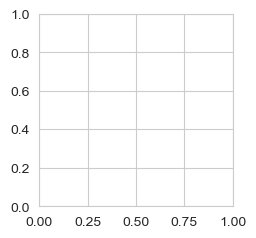

In [268]:

df = pd.DataFrame(rows)
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec

fig = plt.figure(figsize=(2.5,2.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.scatterplot(data = df[df.step==99],x='x',y='y',hue = 'run',ax=ax,legend=False,edgecolor=None)
#sns.scatterplot(data = df[df.run==999],x='x',y='y',hue = 'step',ax=ax,legend=False,edgecolor=None)
sns.scatterplot(x=[2.65],y=[-2.4],marker='+',color='black')
sns.scatterplot(x=[initial_state[0]],y=[initial_state[1]],marker='+',color='orange')
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)

### Testing world model

In [429]:
# Initialize state
initial_state = env.reset()
initial_state = torch.tensor(np.concatenate([initial_state[0]['observation'], initial_state[0]['desired_goal']])).float()

# Initialize models
# actor_network = ActorNet()
#world_network = WorldNet()
actor_network.eval()
world_network.eval()

# Set current state to initial_state
state = initial_state.clone()

# Real trajectory
# Store first state
rows = []
rows.append({'step':0,
             'x':state[0],
             'y':state[1]})
print(state)
# Loop over steps
for step in range(1, MAX_STEPS):
    
    # Get action for current state
    action = actor_network(state)
    
    # Take environment step via action
    new_state, reward, _, _, _ = env.step(action.detach())
    
    # Reshape new state for actor in next step
    new_state = torch.tensor(np.concatenate([new_state['observation'],new_state['desired_goal']])).float()
    rows.append({'step':step,
             'x':new_state[0].item(),
             'y':new_state[1].item()})
    
    # Set state to new state
    state = new_state.clone()
real_df = pd.DataFrame(rows)    


# Predicted trajectory
# Re-initialize state
state = initial_state.clone()
print(state)
# Store first state
new_rows = []
new_rows.append({'step':0,
             'x':initial_state[0],
             'y':initial_state[1]})

# Loop over steps
for step in range(1,MAX_STEPS):
    
    # Select action for state
    action = actor_network(state)
    
    # Generate predicted next state 
    new_state_prediction,reward_prediction = world_network(torch.concatenate([state,action]))
    
    # Store new state
    new_rows.append({'step':step,
             'x':new_state_prediction[0].item(),
             'y':new_state_prediction[1].item()})
    
    # Set state to new state
    state = new_state_prediction.clone()
model_df = pd.DataFrame(new_rows)    


fig = plt.figure(figsize=(7.5,7.5))
gs = gridspec.GridSpec(1,1)
ax=fig.add_subplot(gs[0,0])
sns.scatterplot(data = real_df,x='x',y='y',hue='step',ax=ax,legend=False,edgecolor=None,s=8)
sns.scatterplot(data = model_df,x='x',y='y',color='blue',ax=ax,legend=False,edgecolor=None,s=6)
ax.set_xlim(-4,4)
ax.set_ylim(-4,4)


tensor([-1.6317,  1.6205,  0.0000,  0.0000,  2.4736, -2.4798])
tensor([-1.6317,  1.6205,  0.0000,  0.0000,  2.4736, -2.4798])


(-4.0, 4.0)

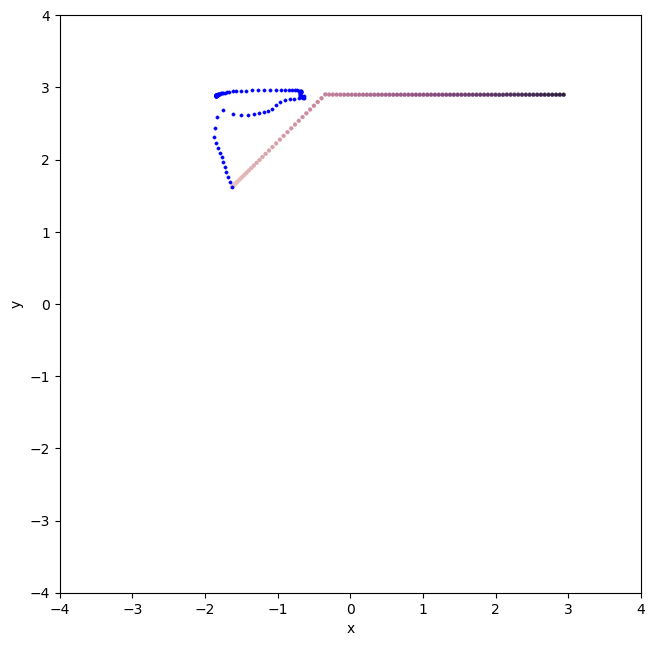

In [418]:
initial_state = env.reset()
initial_state = torch.tensor(np.concatenate([initial_state[0]['observation'],initial_state[0]['desired_goal']])).float()


In [419]:
action = actor_network(initial_state)
new_state, reward, _, _, _ = env.step(action.detach())
new_state_prediction,reward_prediction = world_network(torch.concatenate([initial_state,action]))
np.round(new_state_prediction.detach(),2)

tensor([ 1.3900,  2.7400,  0.4800,  0.2100,  2.7200, -2.2600])

In [420]:
new_state['observation']

array([1.4200234 , 2.73829975, 0.23517743, 0.22633259])

In [417]:
world_network(torch.concatenate([initial_state,action]))

(tensor([ 1.5968, -2.4374,  0.1522,  0.0980,  2.4357, -2.5896],
        grad_fn=<SqueezeBackward4>),
 tensor(0.3635, grad_fn=<ExpBackward0>))

In [106]:
new_state_prediction,reward_prediction

(tensor([ 2.6284, -1.0226,  1.2413, -0.4143,  3.2101, -2.6857],
        grad_fn=<SqueezeBackward4>),
 tensor([0.0075], grad_fn=<SigmoidBackward0>))

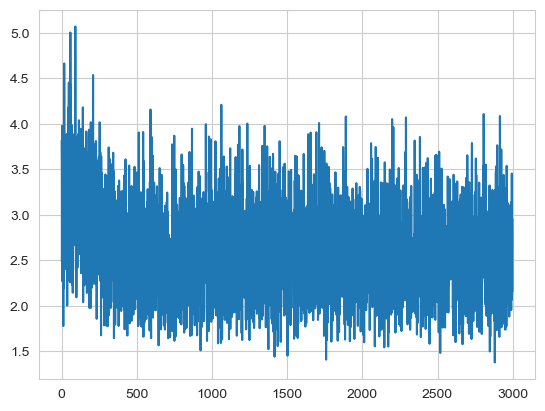

In [466]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(episode_rewards)

In [14]:
optimizer = torch.optim.SGD(world_network.parameters(), lr=.001,weight_decay = 0)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1,end_factor=.01, total_iters=10)

NUM_EPOCHS = 100
for i in range(NUM_EPOCHS):
        scheduler.step()
        print(scheduler.get_last_lr())

[0.000901]
[0.000802]
[0.000703]
[0.0006039999999999999]
[0.0005049999999999999]
[0.00040599999999999995]
[0.000307]
[0.00020800000000000001]
[0.000109]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.999999999999989e-06]
[9.9999

/Users/cl1704/anaconda3/envs/myoenv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
